In [ ]:
!nvidia-smi

Fri Sep 18 14:08:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import random
import math
from datetime import timedelta, datetime
import dateutil
import sys
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
path = '/content/gdrive/My Drive/Dacon/HAI 2.0/'

path_train = path + 'training'
path_valid = path + 'validation'
path_test = path + 'testing'
path_submission = path

seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)

# these change models
timelen = 100
stride = 3
ModelNames = [('HAI_2_front','HAI_2_back')]
you
# these can be changed any time
epoch = 70
batch_size = 32
verbose = 1
optim = 'adam' # tfa.optimizers.SWA(tf.keras.optimizers.SGD())

In [ ]:
def plot_history(history):
    plt.rcParams['figure.figsize'] = [10, 5]
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.plot(history.history['accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')

    ax2.plot(history.history['loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')

    plt.show()

def get_progressbar_str(progress):
    MAX_LEN = 30
    BAR_LEN = int(MAX_LEN * progress)
    return ('Progress:[' + '=' * BAR_LEN +
            ('>' if BAR_LEN < MAX_LEN else '') +
            ' ' * (MAX_LEN - BAR_LEN) +
            '] %.1f%%' % (progress * 100.))
    
def check_timestamp_continuous(df):
    temp = df.iloc[:,0]
    for i in range(len(temp)-1):
        if dateutil.parser.parse(temp.iloc[i+1]) - dateutil.parser.parse(temp.iloc[i]) != timedelta(seconds=1):  #parse 는 자동으로 datetime object 를 생성. datetime - datetime 은 timedelta object 생성.
            return False
    return True

def put_labels(submission, threshold):
    temp = np.zeros_like(submission, dtype = 'int8')
    temp[submission > threshold] = 1
    return temp

In [ ]:
def read_data(path,att=False):
    file_paths = glob.glob(path+'/*.csv')
    df = pd.DataFrame()
    for file in file_paths:
        f=pd.read_csv(file)
        print('Time Continuity : ',check_timestamp_continuous(f), ',  Attack :',att)
        df = df.append(f, ignore_index=True)
    if att:
        return df
    else:
        C_cols = list(df.columns)
        C_cols.remove('time')
        return df, C_cols

train_raw, C_cols = read_data(path_train)
valid_raw = read_data(path_valid,att=True)

Time Continuity :  True ,  Attack : False
Time Continuity :  True ,  Attack : False
Time Continuity :  True ,  Attack : False
Time Continuity :  True ,  Attack : True


In [ ]:
class HAI_dataset():
    def __init__(self, df, timelen, stride, C_cols, scaler = None):
        if scaler:
            self.data = scaler.transform(df[C_cols].values)
            self.scaler = scaler
        else:
            scaler = MinMaxScaler()
            self.data = scaler.fit_transform(df[C_cols].values)
            self.scaler = scaler
        self.timelen = timelen
        idxs = []
        for i in range(0, len(df) - timelen, stride):
            if dateutil.parser.parse(df.iloc[i + timelen - 1, 0]) - dateutil.parser.parse(df.iloc[i, 0]) in [timedelta(seconds=timelen - 1), -timedelta(seconds=timelen - 1)]:  # parse 는 자동으로 datetime object 를 생성. datetime - datetime 은 timedelta object 생성.
                idxs.append(i)
        self.idxs = np.array(idxs)
        self.n_idxs = len(self.idxs)
        print(f"# of valid windows: {self.n_idxs}")

    def __getitem__(self, idx):
        i = self.idxs[idx]
        # X 는 timelen - 1 개, Y까지 하면 timelen 개 이다. 그래서 dateutil 로 처리하면 (i+timelen-1) - (i) == timelen-1 이다. (0부터 10까지를 생각해 보자.)
        X = self.data[i: i + self.timelen - 1]  
        Y = self.data[i + self.timelen - 1]
        return X, Y

    def __len__(self):
        return len(self.idxs)

class Dataset_Batch_Loader(keras.utils.Sequence):
    def __init__(self, Dataset, batch_size, randomize = True, val_split = None):  # val_split = 0.99 추천
        self.dataset = Dataset
        self.batch_size = batch_size
        self.length = math.ceil(len(Dataset) / batch_size)
        if randomize:
            idxs = np.arange(len(Dataset))
            random.shuffle(idxs)
            self.randomized_idxs = np.array(idxs)
        else:
            self.randomized_idxs = np.arange(len(Dataset))

        if val_split:
            point = int(len(self.randomized_idxs) * val_split)
            self.val_idxs = self.randomized_idxs[point:]
            self.randomized_idxs = self.randomized_idxs[:point]
            self.length = math.ceil(len(self.randomized_idxs) / batch_size)

    def __getitem__(self, idx):
        i = idx * self.batch_size
        if i + self.batch_size < len(self.dataset):
            index_window = [j for j in self.randomized_idxs[i:i + self.batch_size]]
        else:
            index_window = [j for j in self.randomized_idxs[i:]]
        X = np.asarray([self.dataset[k][0] for k in index_window])
        Y = np.asarray([self.dataset[k][1] for k in index_window])
        return X, [X, Y]

    def __len__(self):
        return self.length

train_class_front = HAI_dataset(train_raw, timelen, stride, C_cols = C_cols)  # front 만 하면 앞에 timelen-1 개만큼 predict 를 못한다. back 까지 하고, 겹치는 부분은 error 에서 평균내자.
train_sequence_front = Dataset_Batch_Loader(train_class_front, batch_size, val_split = 0.9)  # , val_split = 0.9
print("Train_front : ",len(train_class_front), len(train_sequence_front))

train_class_back = HAI_dataset(train_raw.iloc[::-1], timelen, stride, C_cols = C_cols)
train_sequence_back = Dataset_Batch_Loader(train_class_back, batch_size, val_split = 0.9)  # , val_split = 0.9
print("Train_back : ",len(train_class_back), len(train_sequence_back))  

scaler= train_class_front.scaler

valid_class_front = HAI_dataset(valid_raw, timelen, stride = 1, C_cols = C_cols, scaler = scaler)
valid_sequence_front = Dataset_Batch_Loader(valid_class_front, batch_size = 100, randomize = False)
print("Valid_front : ",len(valid_class_front), len(valid_sequence_front))

valid_class_back = HAI_dataset(valid_raw.iloc[::-1], timelen, stride = 1, C_cols = C_cols, scaler = scaler)
valid_sequence_back = Dataset_Batch_Loader(valid_class_back, batch_size = 100, randomize = False)
print("Valid_back : ",len(valid_class_back), len(valid_sequence_back))

valid_label = valid_raw['attack'].values

# of valid windows: 307102
Train_front :  307102 8638
# of valid windows: 307102
Train_back :  307102 8638
# of valid windows: 43101
Valid_front :  43101 432
# of valid windows: 43101
Valid_back :  43101 432


In [ ]:
train_sequence_front[0][0].shape, train_sequence_front[0][1][0].shape, train_sequence_front[0][1][1].shape

((32, 99, 79), (32, 99, 79), (32, 79))

In [ ]:
def val_data(dataset, index_window):
    X = np.asarray([dataset[k][0] for k in index_window])
    Y = np.asarray([dataset[k][1] for k in index_window])
    return X, [X, Y]

train_val_front = val_data(train_class_front, train_sequence_front.val_idxs)
train_val_back = val_data(train_class_back, train_sequence_back.val_idxs)
print(train_val_front[0].shape, train_val_back[0].shape, train_val_front[1][1].shape, train_val_back[1][1].shape)

(30711, 99, 79) (30711, 99, 79) (30711, 79) (30711, 79)


In [ ]:
# only for training...
def generate_and_train_model(train_sequence, epoch, batch_size, val, Modelname):  # loss 에서 대회 주어진거 사용해야할듯
    print("Starting to train ",Modelname)
    callbacks1 = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True), ReduceLROnPlateau(monitor = 'loss', patience = 10)]
    with tf.device('/device:GPU:0'):
        inp = layers.Input(shape = (timelen-1,79))
        enc = layers.LSTM(2 * timelen)(inp)

        dec1 = layers.RepeatVector(n = timelen-1)(enc)
        dec1 = layers.LSTM(2 * timelen,return_sequences=True)(dec1)
        dec1 = layers.TimeDistributed(layers.Dense(79, activation = 'relu'))(dec1)

        dec2 = layers.Dense(timelen, activation = 'relu')(enc)
        dec2 = layers.Dense(79, activation = 'relu')(dec2)

        model = keras.Model(inputs = inp, outputs = [dec1, dec2])
        model.compile(optimizer=optim,loss='MAE')
        print(model.summary())
        history = model.fit(train_sequence, epochs=epoch, verbose=2, validation_data = val, callbacks = callbacks1) #, callbacks = callbacks1
    model.save(path + Modelname + '.h5')
    print("...model saved !")
    return history

H = []
def front_and_back(ModelNames):
    for Modelname in ModelNames:
        tf.keras.backend.clear_session()
        H.append(generate_and_train_model(train_sequence_front, epoch, batch_size, train_val_front, Modelname[0]))
        H.append(generate_and_train_model(train_sequence_back, epoch, batch_size, train_val_back, Modelname[1]))

front_and_back(ModelNames)

Starting to train  HAI_2_front
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 99, 79)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 200)          224000      input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 99, 200)      0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 99, 200)      320800      repeat_vector[0][0]              
________________________________________________________

In [ ]:
def validation_test(valid_sequence_front, valid_sequence_back, valid_label, ModelNames): # 일단 validation 은 파일이 한개이고 연속이므로 그렇게 가정하고 간다.
    batch_idxs = [i for i in range(0, len(valid_sequence_front))]
    batch_size = valid_sequence_front.batch_size
    submission = pd.Series(np.zeros_like(valid_label))
    inc = 0
    L = len(batch_idxs) * 2 * len(ModelNames)
    for Modelname in ModelNames:
        tf.keras.backend.clear_session()
        model_front = tf.keras.models.load_model(path+Modelname[0]+'.h5')
        for batch_idx in batch_idxs:
            target = valid_sequence_front[batch_idx][1][0]
            real_data = valid_sequence_front[batch_idx][1][1]
            real_idxs = [i for i in range( timelen + batch_size * batch_idx, timelen + batch_size * batch_idx + len(target) ) ]
            with tf.device('/device:GPU:0'):
                predicted_front = model_front.predict(target)
            submission[real_idxs] += np.asarray(list(map(np.mean, np.abs(real_data - np.asarray(predicted_front[1]))))) 
            inc += 1
            sys.stderr.write('\r\033[K' + get_progressbar_str(inc/L))
            sys.stderr.flush()

        model_back = tf.keras.models.load_model(path+Modelname[1]+'.h5')
        for batch_idx in batch_idxs:
            target = valid_sequence_back[batch_idx][1][0]
            real_data = valid_sequence_back[batch_idx][1][1]
            real_idxs = [i for i in range( len(submission) - 1 - timelen - batch_size * batch_idx, len(submission) - 1 - timelen - batch_size * batch_idx - len(target), -1 ) ]
            with tf.device('/device:GPU:0'):
                predicted_back = model_back.predict(target)
            submission[real_idxs] += np.asarray(list(map(np.mean, np.abs(real_data - np.asarray(predicted_back[1])))))
            inc += 1
            sys.stderr.write('\r\033[K' + get_progressbar_str(inc/L))
            sys.stderr.flush()

    submission[:timelen] = submission[:timelen] / len(ModelNames)
    submission[timelen:len(submission) - timelen + 1] = submission[timelen:len(submission) - timelen + 1] / (2 * len(ModelNames))
    submission[len(submission) - timelen + 1:] = submission[len(submission) - timelen + 1:] / len(ModelNames)
    print("Done !")

    return submission

submission_val = validation_test(valid_sequence_front, valid_sequence_back, valid_label, ModelNames)

Progress:[==============================] 100.0%

Done !


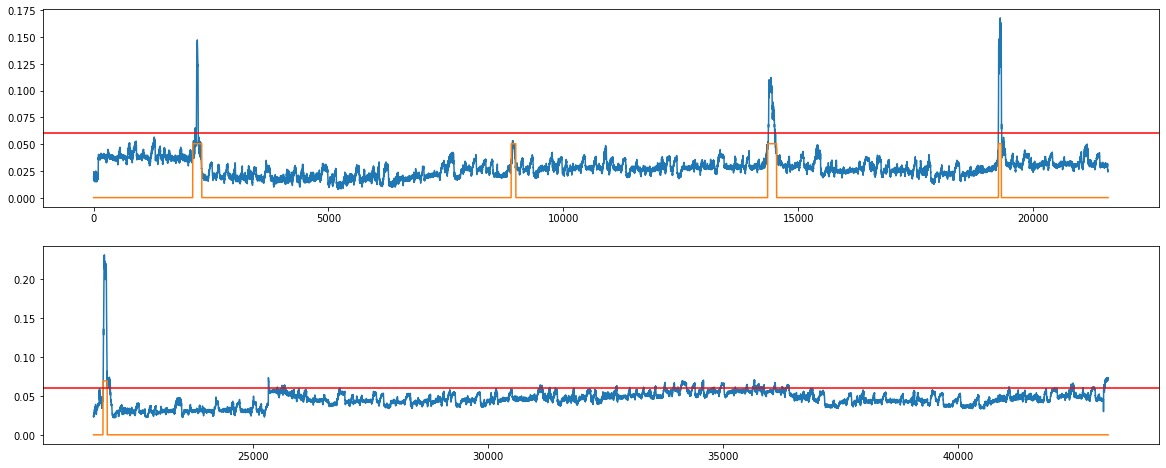

In [ ]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

check_graph(submission_val.values, valid_label, THRESHOLD= 0.06)

In [ ]:
! pip install '/content/gdrive/My Drive/Dacon/HAI 2.0/eTaPR-1.12-py3-none-any.whl'

Processing ./gdrive/My Drive/Dacon/HAI 2.0/eTaPR-1.12-py3-none-any.whl


In [ ]:
from TaPR_pkg import etapr

In [ ]:
# 먼저 어디부터 어디까지로 할지 정해야 한다.
final = put_labels(submission_val.values, 0.08)
TaPR = etapr.evaluate(anomalies=valid_label, predictions=final)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.787 (TaP: 0.976, TaR: 0.659)
# of detected anomalies: 4
Detected anomalies: ['1', '3', '4', '5']


In [ ]:
res = []
ff = 0.08
ee = 0.09
NN = 1000
inc = 0
for i in range(NN):
    th = ff + i * (ee-ff)/NN
    final = put_labels(submission_val.values, th)
    TaPR = etapr.evaluate(anomalies=valid_label, predictions=final)
    res.append((TaPR['f1'],th))
    inc += 1
    sys.stderr.write('\r\033[K' + get_progressbar_str(inc/NN))
    sys.stderr.flush()
_, threshold = max(res)
final = put_labels(submission_val.values, threshold)
TaPR = etapr.evaluate(anomalies=valid_label, predictions=final)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")
print("Threshold : ",threshold)

Progress:[==============================] 100.0%

F1: 0.793 (TaP: 1.000, TaR: 0.658)
# of detected anomalies: 4
Detected anomalies: ['1', '3', '4', '5']
Threshold :  0.08169


only for test

Starting for test  1
# of valid windows: 118701
Test_front :  118701 119
# of valid windows: 118701
Test_back :  118701 119


Progress:[==============================] 100.0%

Done !
Starting for test  2
# of valid windows: 107901
Test_front :  107901 108
# of valid windows: 107901
Test_back :  107901 108


Progress:[==============================] 100.0%

Done !
Starting for test  3
# of valid windows: 39501
Test_front :  39501 40
# of valid windows: 39501
Test_back :  39501 40


Progress:[==============================] 100.0%

Done !
Starting for test  4
# of valid windows: 92301
Test_front :  92301 93
# of valid windows: 92301
Test_back :  92301 93


Progress:[==============================] 100.0%

Done !


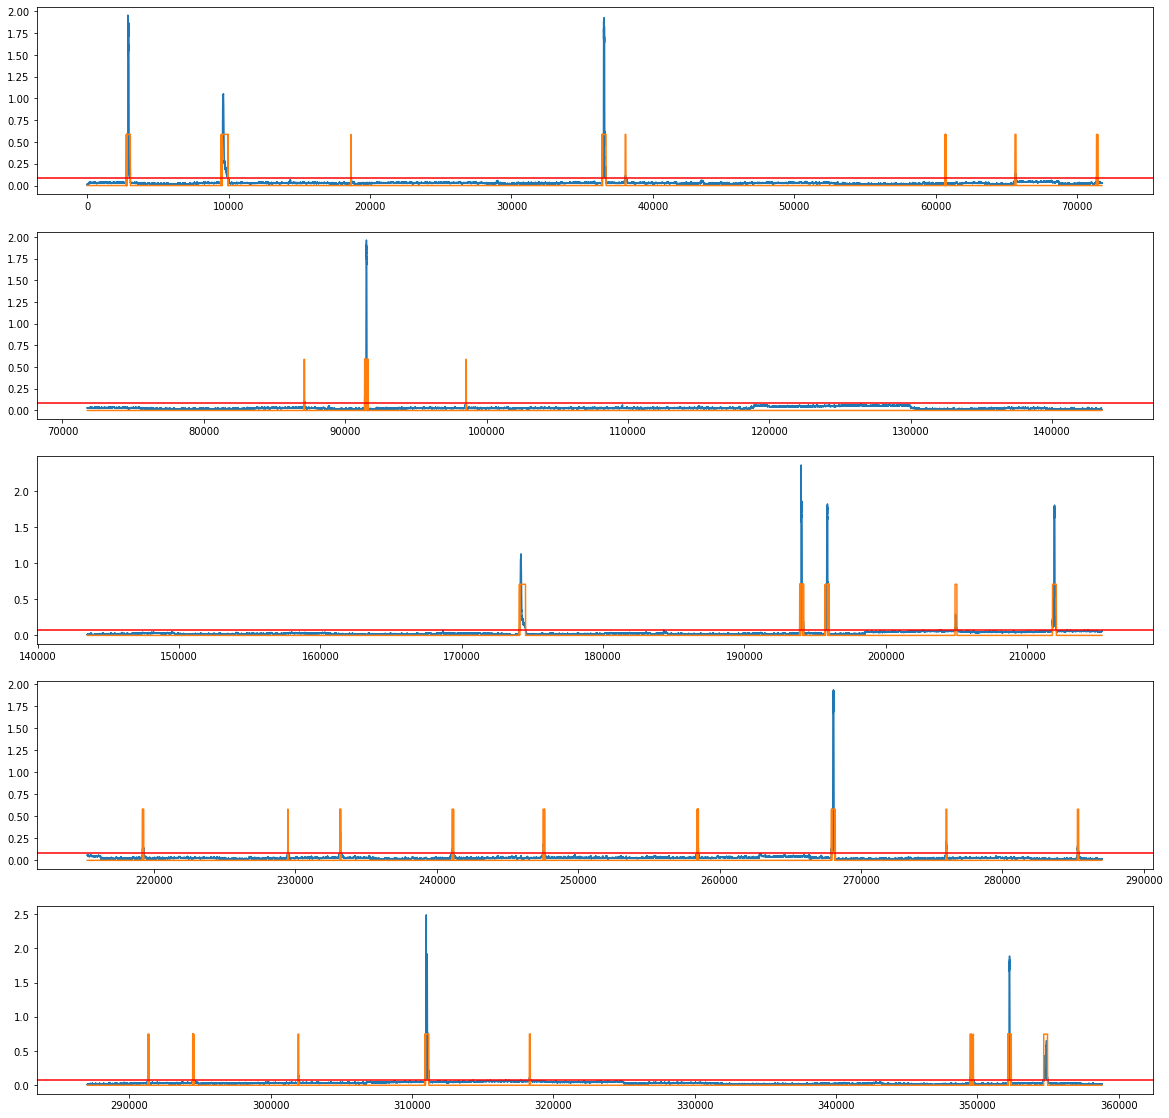

In [ ]:
# iter every test data (1~4)
file_paths = glob.glob(path_test+'/*.csv')
submission = pd.read_csv(path + '/sample_submission.csv')
submission_final = submission.reindex(submission['time'])
submission_final['time'] = submission['time']

for T, file in enumerate(file_paths):
    print("Starting for test ",T+1)
    test_raw = pd.read_csv(file)
    # print('Time Continuity : ',check_timestamp_continuous(test_raw))

    test_class_front = HAI_dataset(test_raw, timelen, stride = 1, C_cols = C_cols, scaler = scaler)
    test_sequence_front = Dataset_Batch_Loader(test_class_front, batch_size = 1000, randomize = False)
    print("Test_front : ",len(test_class_front), len(test_sequence_front))

    test_class_back = HAI_dataset(test_raw.iloc[::-1], timelen, stride = 1, C_cols = C_cols, scaler = scaler)
    test_sequence_back = Dataset_Batch_Loader(test_class_back, batch_size = 1000, randomize = False)
    print("Test_back : ",len(test_class_back), len(test_sequence_back))
    sub = validation_test(test_sequence_front, test_sequence_back, test_raw['time'], ModelNames)
    submission_final.loc[test_raw['time'],'attack'] = sub.values

submission['attack'] = put_labels(submission_final['attack'].values, threshold)
submission.to_csv(path+'submission_'+str(ModelNames[0][0])+str(len(ModelNames))+'_TH_'+str(threshold)+'.csv',index = False)

check_graph(submission_final['attack'].values, submission['attack'], piece=5, THRESHOLD=threshold)


In [ ]:
submission = pd.read_csv(path + '/sample_submission.csv')
submission['attack'] = put_labels(submission_final['attack'].values, threshold)
submission.to_csv(path+'submission_'+str(ModelNames[0][0])+str(len(ModelNames))+'_TH_'+str(threshold)+'.csv',index = False)

In [ ]:
sub

0          0.0113746
1         0.00858294
2          0.0094012
3          0.0109604
4           0.010646
             ...    
118796     0.0102474
118797    0.00883894
118798     0.0105315
118799     0.0119387
118800    0.00835679
Length: 118801, dtype: object

In [ ]:
submission

,time,attack
0,2020-07-09 15:00:00,0
1,2020-07-09 15:00:01,0
2,2020-07-09 15:00:02,0
3,2020-07-09 15:00:03,0
4,2020-07-09 15:00:04,0
...,...,...
358799,2020-07-31 12:29:56,0
358800,2020-07-31 12:29:57,0
358801,2020-07-31 12:29:58,0
358802,2020-07-31 12:29:59,0
